In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import datetime
import numpy as np

In [10]:
def get_working_dir():
    return Path.cwd()

processed_dir = get_working_dir() / 'data' / 'processed'
os.makedirs(processed_dir, exist_ok=True)

df_t = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_affect.csv', encoding='utf-8')
df_m = pd.read_csv(get_working_dir() /  'data' / 'processed' / 'm_affect.csv', encoding='utf-8')
df_m_t = pd.read_csv(get_working_dir() /  'data' / 'processed' / 'm_t_affect.csv', encoding='utf-8')

In [11]:
processed_dir = get_working_dir() / 'data' / 'processed'
os.makedirs(processed_dir, exist_ok=True)

# Create plots/demographics directory
results_dir = get_working_dir() / 'plots' / 'demographics'
os.makedirs(results_dir, exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = results_dir / timestamp
os.makedirs(save_dir, exist_ok=True)

Affect states detected: ['upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous', 'determined', 'attentive', 'afraid', 'active']


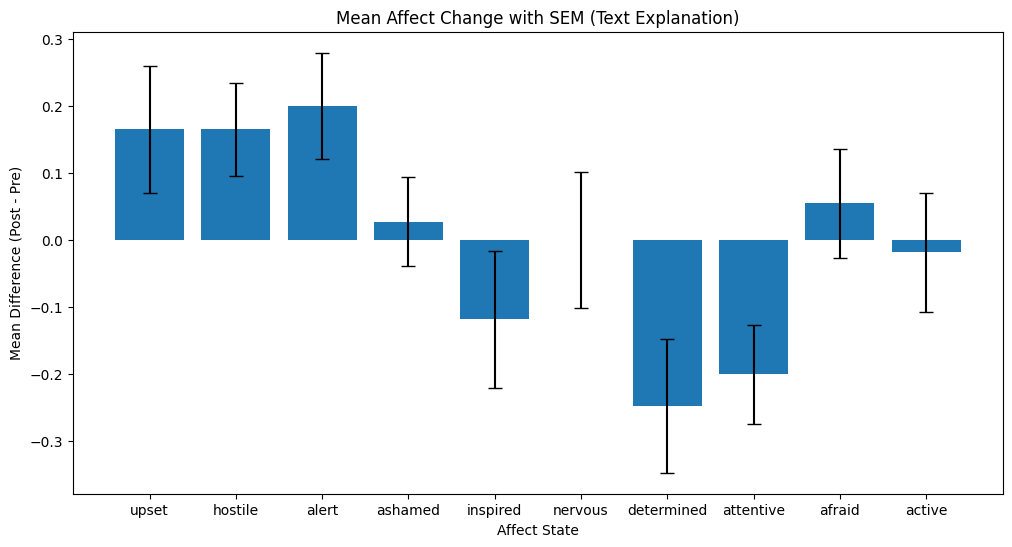

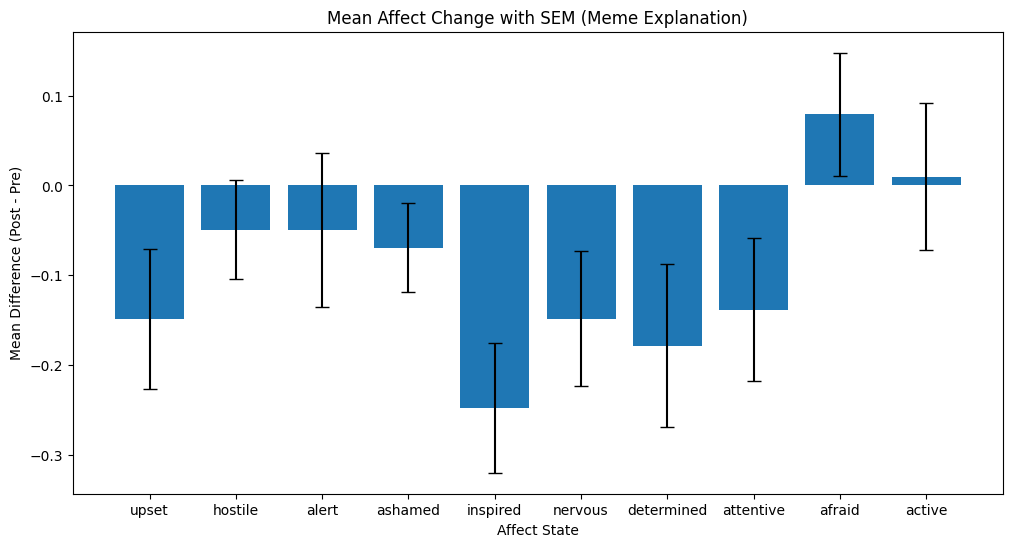

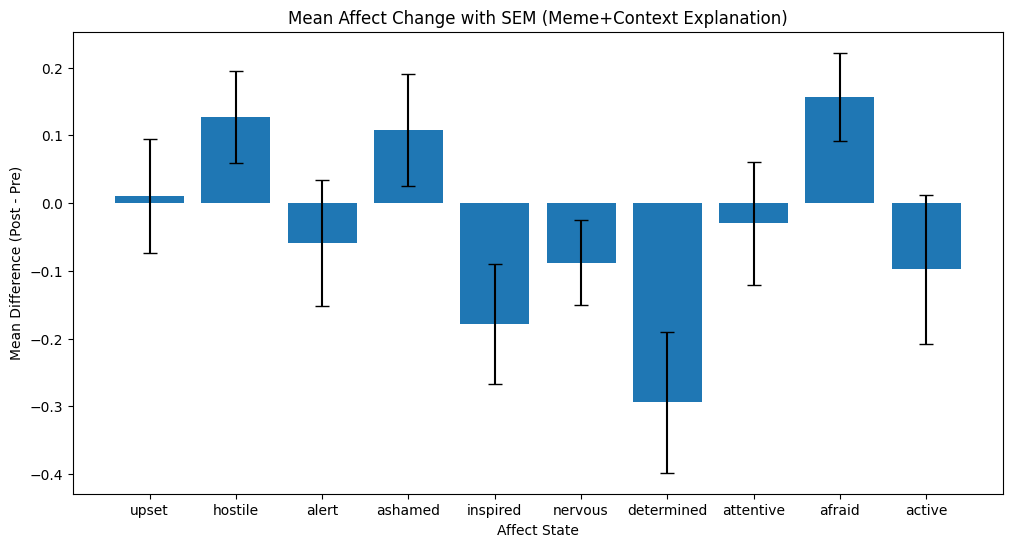

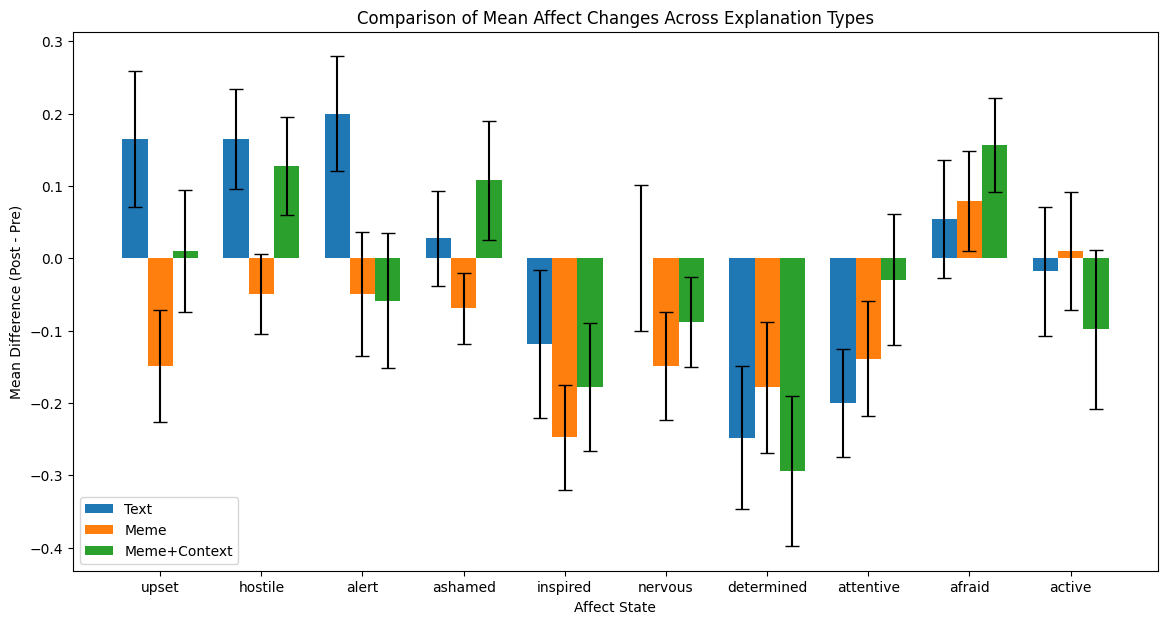

In [13]:
# --- STEP 1: Setup directories and load data ---
def get_working_dir():
    return Path.cwd()

processed_dir = get_working_dir() / 'data' / 'processed'
os.makedirs(processed_dir, exist_ok=True)

# Load the CSV files
df_t   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_affect.csv', encoding='utf-8')
df_m   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_affect.csv', encoding='utf-8')
df_m_t = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_affect.csv', encoding='utf-8')

# Create a plots directory to save plots
results_dir = get_working_dir() / 'plots' / 'demographics'
os.makedirs(results_dir, exist_ok=True)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = results_dir / timestamp
os.makedirs(save_dir, exist_ok=True)

# --- STEP 2: Define the ordinal mapping ---
# Map responses from 1 ("Not at all") to 5 ("Extremely"); "I prefer not to answer" -> NaN
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5,
    "I prefer not to answer": np.nan
}

# --- STEP 3: Identify affect states ---
affect_states = [col.split("pre_")[-1] for col in df_t.columns if col.startswith("pre_")]
print("Affect states detected:", affect_states)

# --- STEP 4: Convert ordinal responses to numeric ---
def convert_affect_scores(df, affect_states, mapping):
    for state in affect_states:
        pre_col  = f'pre_{state}'
        post_col = f'post_{state}'
        df[pre_col]  = df[pre_col].map(mapping)
        df[post_col] = df[post_col].map(mapping)
    return df

df_t   = convert_affect_scores(df_t, affect_states, affect_mapping)
df_m   = convert_affect_scores(df_m, affect_states, affect_mapping)
df_m_t = convert_affect_scores(df_m_t, affect_states, affect_mapping)

# --- STEP 5: Compute differences (post - pre) for each affect state ---
def compute_differences(df, affect_states):
    for state in affect_states:
        df[f'diff_{state}'] = df[f'post_{state}'] - df[f'pre_{state}']
    return df

df_t   = compute_differences(df_t, affect_states)
df_m   = compute_differences(df_m, affect_states)
df_m_t = compute_differences(df_m_t, affect_states)

# --- STEP 6: Helper function to plot and save bar charts ---
def plot_and_save_mean_changes(df, study_label, filename):
    """
    Creates a bar chart of mean differences (Post - Pre) for each affect state,
    with error bars representing the standard error of the mean (SEM).
    """
    means = [df[f'diff_{state}'].mean() for state in affect_states]
    sems  = [df[f'diff_{state}'].sem() for state in affect_states]

    plt.figure(figsize=(12, 6))
    plt.bar(affect_states, means, yerr=sems, capsize=5)
    plt.title(f"Mean Affect Change with SEM ({study_label})")
    plt.xlabel("Affect State")
    plt.ylabel("Mean Difference (Post - Pre)")
    plt.savefig(save_dir / filename, bbox_inches="tight")
    plt.show()
    plt.close()

# --- STEP 7: Generate and save bar charts for each study ---
plot_and_save_mean_changes(df_t,   "Text Explanation",          "barplot_text_explanation.png")
plot_and_save_mean_changes(df_m,   "Meme Explanation",          "barplot_meme_explanation.png")
plot_and_save_mean_changes(df_m_t, "Meme+Context Explanation",  "barplot_meme_context_explanation.png")

# --- STEP 8: Grouped bar chart comparing explanation types ---
means_t  = [df_t[f'diff_{state}'].mean() for state in affect_states]
means_m  = [df_m[f'diff_{state}'].mean() for state in affect_states]
means_mt = [df_m_t[f'diff_{state}'].mean() for state in affect_states]

sems_t   = [df_t[f'diff_{state}'].sem() for state in affect_states]
sems_m   = [df_m[f'diff_{state}'].sem() for state in affect_states]
sems_mt  = [df_m_t[f'diff_{state}'].sem() for state in affect_states]

x = np.arange(len(affect_states))
width = 0.25

plt.figure(figsize=(14, 7))
plt.bar(x - width, means_t,  width, yerr=sems_t,  capsize=5, label='Text')
plt.bar(x,         means_m,  width, yerr=sems_m,  capsize=5, label='Meme')
plt.bar(x + width, means_mt, width, yerr=sems_mt, capsize=5, label='Meme+Context')

plt.xlabel("Affect State")
plt.ylabel("Mean Difference (Post - Pre)")
plt.xticks(x, affect_states)
plt.title("Comparison of Mean Affect Changes Across Explanation Types")
plt.legend()

plt.savefig(save_dir / "grouped_bar_chart_explanation_types.png", bbox_inches="tight")
plt.show()
plt.close()

# Internal Consistency of the PRE PA and NA samples

In [15]:
import numpy as np
# Function to calculate Cronbach's alpha for a given set of items
def cronbach_alpha(df_items):
    """
    Computes Cronbach's alpha for a DataFrame of items.
    Rows are subjects and columns are items.
    """
    k = df_items.shape[1]
    # Variance for each item
    item_variances = df_items.var(ddof=1)
    # Variance of the total score (sum across items)
    total_var = df_items.sum(axis=1).var(ddof=1)
    # Cronbach's alpha formula
    alpha = (k / (k - 1)) * (1 - item_variances.sum() / total_var)
    return alpha

# Bootstrap function to estimate a 95% confidence interval for Cronbach's alpha
def bootstrap_cronbach_alpha(df_items, n_bootstrap=1000, random_state=None):
    """
    Uses bootstrapping to compute a 95% CI for Cronbach's alpha.
    """
    alphas = []
    np.random.seed(random_state)
    n = df_items.shape[0]
    for _ in range(n_bootstrap):
        sample_df = df_items.sample(n=n, replace=True)
        alphas.append(cronbach_alpha(sample_df))
    lower = np.percentile(alphas, 2.5)
    upper = np.percentile(alphas, 97.5)
    return lower, upper

# Function to compute the desired statistics for a scale
def compute_scale_stats(df, items, prefix='pre_'):
    """
    Given a DataFrame `df`, a list of item names, and a prefix (e.g., 'pre_'),
    this function computes:
      - Cronbach's alpha
      - 95% confidence interval for alpha (via bootstrapping)
      - Mean scale score (average across items for each subject)
      - Standard deviation of scale scores
    Rows with any missing values (NaNs) in the items are dropped.
    """
    # Create the list of columns based on the provided prefix and item names
    cols = [f'{prefix}{item}' for item in items]
    # Use only complete cases for these items
    df_scale = df[cols].dropna()
    
    # Compute Cronbach's alpha and its bootstrap CI
    alpha = cronbach_alpha(df_scale)
    ci_lower, ci_upper = bootstrap_cronbach_alpha(df_scale, n_bootstrap=1000, random_state=42)
    
    # Compute scale scores as the average across items for each subject
    scale_scores = df_scale.mean(axis=1)
    mean_score = scale_scores.mean()
    sd_score = scale_scores.std(ddof=1)
    
    return alpha, ci_lower, ci_upper, mean_score, sd_score

# Define the affect items for Positive Affect (PA) and Negative Affect (NA)
pa_items = ['active', 'determined', 'attentive', 'inspired', 'alert']
na_items = ['afraid', 'nervous', 'upset', 'hostile', 'ashamed']

# For demonstration, assume we use df_t (e.g., from the text study)
# The DataFrame should already have the pre_ columns mapped to numeric values.
alpha_pa, ci_lower_pa, ci_upper_pa, mean_pa, sd_pa = compute_scale_stats(df_t, pa_items, prefix='pre_')
alpha_na, ci_lower_na, ci_upper_na, mean_na, sd_na = compute_scale_stats(df_t, na_items, prefix='pre_')

print("Positive Affect (PA) Scale:")
print(f"  Cronbach's alpha: {alpha_pa:.2f}")
print(f"  95% CI: [{ci_lower_pa:.2f}, {ci_upper_pa:.2f}]")
print(f"  Mean: {mean_pa:.2f}")
print(f"  SD: {sd_pa:.2f}\n")

print("Negative Affect (NA) Scale:")
print(f"  Cronbach's alpha: {alpha_na:.2f}")
print(f"  95% CI: [{ci_lower_na:.2f}, {ci_upper_na:.2f}]")
print(f"  Mean: {mean_na:.2f}")
print(f"  SD: {sd_na:.2f}")

Positive Affect (PA) Scale:
  Cronbach's alpha: 0.76
  95% CI: [0.66, 0.83]
  Mean: 3.19
  SD: 0.79

Negative Affect (NA) Scale:
  Cronbach's alpha: 0.93
  95% CI: [0.90, 0.96]
  Mean: 1.59
  SD: 0.95


# Internal Consistency of the POST PA and NA samples

In [16]:
# For demonstration, assume we use df_t (e.g., from the text study)
# The DataFrame should already have the pre_ columns mapped to numeric values.
alpha_pa, ci_lower_pa, ci_upper_pa, mean_pa, sd_pa = compute_scale_stats(df_t, pa_items, prefix='post_')
alpha_na, ci_lower_na, ci_upper_na, mean_na, sd_na = compute_scale_stats(df_t, na_items, prefix='post_')

print("Positive Affect (PA) Scale:")
print(f"  Cronbach's alpha: {alpha_pa:.2f}")
print(f"  95% CI: [{ci_lower_pa:.2f}, {ci_upper_pa:.2f}]")
print(f"  Mean: {mean_pa:.2f}")
print(f"  SD: {sd_pa:.2f}\n")

print("Negative Affect (NA) Scale:")
print(f"  Cronbach's alpha: {alpha_na:.2f}")
print(f"  95% CI: [{ci_lower_na:.2f}, {ci_upper_na:.2f}]")
print(f"  Mean: {mean_na:.2f}")
print(f"  SD: {sd_na:.2f}")

Positive Affect (PA) Scale:
  Cronbach's alpha: 0.84
  95% CI: [0.79, 0.89]
  Mean: 3.11
  SD: 0.93

Negative Affect (NA) Scale:
  Cronbach's alpha: 0.88
  95% CI: [0.82, 0.92]
  Mean: 1.64
  SD: 0.87


# I-PANAS-SF reference values

## (PA: alpha = .75, 95% CI: .71 -.78, M = 3.82, SD = .67; NA: alpha = .80, 95% CI: .76 -.82, M = 1.91, SD = .77)

--------------------------------------------------------------------------------------------------------

# Multi-Sample Goodness-of-Fit baseline model US PRE

In [26]:
from semopy import Model, calc_stats

# Load the three CSV files
df_t   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_affect.csv', encoding='utf-8')
df_m   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_affect.csv', encoding='utf-8')
df_m_t = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_affect.csv', encoding='utf-8')

# --- Step 1: Map ordinal responses to numeric values ---
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5,
    "I prefer not to answer": np.nan
}

def map_pre_columns(df):
    pre_columns = [col for col in df.columns if col.startswith("pre_")]
    for col in pre_columns:
        df[col] = df[col].map(affect_mapping)
    return df

df_t   = map_pre_columns(df_t)
df_m   = map_pre_columns(df_m)
df_m_t = map_pre_columns(df_m_t)

# --- Step 2: Concatenate the data to form a US sample ---
df_us = pd.concat([df_t, df_m, df_m_t], ignore_index=True)

# --- Step 3: Prepare data for CFA ---
cfa_cols = ['pre_active', 'pre_determined', 'pre_attentive', 'pre_inspired', 'pre_alert',
            'pre_afraid', 'pre_nervous', 'pre_upset', 'pre_hostile', 'pre_ashamed']
df_us_complete = df_us.dropna(subset=cfa_cols)

# --- Step 4: Define the Two-Factor CFA Model ---
model_desc = """
PA =~ pre_active + pre_determined + pre_attentive + pre_inspired + pre_alert
NA =~ pre_afraid + pre_nervous + pre_upset + pre_hostile + pre_ashamed
"""

# --- Step 5: Fit the CFA Model using semopy ---
model = Model(model_desc)
model.fit(df_us_complete)

# --- Step 6: Calculate and Print Fit Statistics ---
stats = calc_stats(model)
chi2   = stats.loc["Value", "chi2"]
dof    = stats.loc["Value", "DoF"]
cfi    = stats.loc["Value", "CFI"]
rmsea  = stats.loc["Value", "RMSEA"]
cmin_df = chi2 / dof

print("Baseline CFA Model Fit Indices for US Sample (Combined):")
print(f"  Chi-square: {chi2:.2f}")
print(f"  Degrees of Freedom: {dof:.0f}")
print(f"  CMIN/df: {cmin_df:.2f}")
print(f"  CFI: {cfi:.2f}")
print(f"  RMSEA: {rmsea:.3f}")

# --- Step 7: Save the plots to a text file ---
results_dir = get_working_dir() / 'plots' / 'cfa'
results_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = results_dir / f"us_cfa_results_{timestamp}.txt"

with open(output_file, "w") as f:
    f.write("Baseline CFA Model Fit Indices for US Sample (Combined):\n")
    f.write(f"  Chi-square: {chi2:.2f}\n")
    f.write(f"  Degrees of Freedom: {dof:.0f}\n")
    f.write(f"  CMIN/df: {cmin_df:.2f}\n")
    f.write(f"  CFI: {cfi:.2f}\n")
    f.write(f"  RMSEA: {rmsea:.3f}\n")

Baseline CFA Model Fit Indices for US Sample (Combined):
  Chi-square: 209.34
  Degrees of Freedom: 34
  CMIN/df: 6.16
  CFI: 0.89
  RMSEA: 0.129


# Multi-Sample Goodness-of-Fit baseline model US PRE

In [29]:
from semopy import Model, calc_stats

# Load the three CSV files
df_t   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_affect.csv', encoding='utf-8')
df_m   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_affect.csv', encoding='utf-8')
df_m_t = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_affect.csv', encoding='utf-8')

# --- Step 1: Map ordinal responses to numeric values ---
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5,
    "I prefer not to answer": np.nan
}

def map_pre_columns(df):
    pre_columns = [col for col in df.columns if col.startswith("post_")]
    for col in pre_columns:
        df[col] = df[col].map(affect_mapping)
    return df

df_t   = map_pre_columns(df_t)
df_m   = map_pre_columns(df_m)
df_m_t = map_pre_columns(df_m_t)

# --- Step 2: Concatenate the data to form a US sample ---
df_us = pd.concat([df_t, df_m, df_m_t], ignore_index=True)

# --- Step 3: Prepare data for CFA ---
cfa_cols = ['post_active', 'post_determined', 'post_attentive', 'post_inspired', 'post_alert',
            'post_afraid', 'post_nervous', 'post_upset', 'post_hostile', 'post_ashamed']
df_us_complete = df_us.dropna(subset=cfa_cols)

# --- Step 4: Define the Two-Factor CFA Model ---
model_desc = """
PA =~ post_active + post_determined + post_attentive + post_inspired + post_alert
NA =~ post_afraid + post_nervous + post_upset + post_hostile + post_ashamed
"""

# --- Step 5: Fit the CFA Model using semopy ---
model = Model(model_desc)
model.fit(df_us_complete)

# --- Step 6: Calculate and Print Fit Statistics ---
stats = calc_stats(model)
chi2   = stats.loc["Value", "chi2"]
dof    = stats.loc["Value", "DoF"]
cfi    = stats.loc["Value", "CFI"]
rmsea  = stats.loc["Value", "RMSEA"]
cmin_df = chi2 / dof

print("Baseline CFA Model Fit Indices for US Sample (Combined):")
print(f"  Chi-square: {chi2:.2f}")
print(f"  Degrees of Freedom: {dof:.0f}")
print(f"  CMIN/df: {cmin_df:.2f}")
print(f"  CFI: {cfi:.2f}")
print(f"  RMSEA: {rmsea:.3f}")

# --- Step 7: Save the plots to a text file ---
results_dir = get_working_dir() / 'plots' / 'cfa'
results_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = results_dir / f"us_cfa_results_{timestamp}.txt"

with open(output_file, "w") as f:
    f.write("Baseline CFA Model Fit Indices for US Sample (Combined):\n")
    f.write(f"  Chi-square: {chi2:.2f}\n")
    f.write(f"  Degrees of Freedom: {dof:.0f}\n")
    f.write(f"  CMIN/df: {cmin_df:.2f}\n")
    f.write(f"  CFI: {cfi:.2f}\n")
    f.write(f"  RMSEA: {rmsea:.3f}\n")

Baseline CFA Model Fit Indices for US Sample (Combined):
  Chi-square: 220.21
  Degrees of Freedom: 34
  CMIN/df: 6.48
  CFI: 0.88
  RMSEA: 0.133


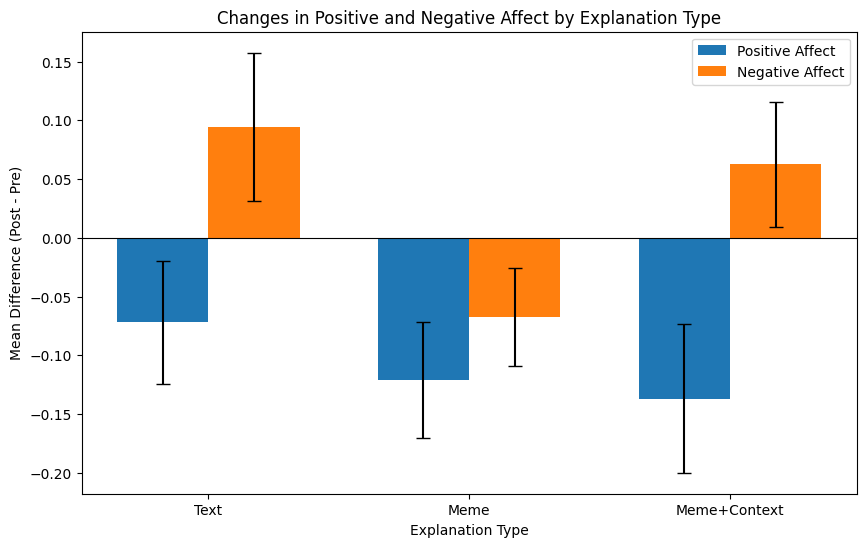

In [31]:
# --- Load the three CSV files ---
df_t   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_affect.csv', encoding='utf-8')
df_m   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_affect.csv', encoding='utf-8')
df_m_t = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_affect.csv', encoding='utf-8')

# --- Step 1: Map ordinal responses to numeric values ---
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5,
    "I prefer not to answer": np.nan
}

def map_pre_columns(df):
    # Process only the columns that start with "pre_"
    pre_columns = [col for col in df.columns if col.startswith("pre_") or col.startswith("post_")]
    for col in pre_columns:
        df[col] = df[col].map(affect_mapping)
    return df

df_t   = map_pre_columns(df_t)
df_m   = map_pre_columns(df_m)
df_m_t = map_pre_columns(df_m_t)

# --- Step 2: Define affect item groups ---
pa_items = ["active", "determined", "attentive", "inspired", "alert"]
na_items = ["afraid", "nervous", "upset", "hostile", "ashamed"]

# --- Step 3: Function to compute aggregated pre, post, and difference scores ---
def compute_affect_diff(df, pa_items, na_items):
    # Build column names
    pre_pa_cols  = [f"pre_{item}" for item in pa_items]
    post_pa_cols = [f"post_{item}" for item in pa_items]
    pre_na_cols  = [f"pre_{item}" for item in na_items]
    post_na_cols = [f"post_{item}" for item in na_items]
    
    # Compute the average for positive affect for each participant
    df["pa_pre"]  = df[pre_pa_cols].mean(axis=1)
    df["pa_post"] = df[post_pa_cols].mean(axis=1)
    df["pa_diff"] = df["pa_post"] - df["pa_pre"]
    
    # Compute the average for negative affect for each participant
    df["na_pre"]  = df[pre_na_cols].mean(axis=1)
    df["na_post"] = df[post_na_cols].mean(axis=1)
    df["na_diff"] = df["na_post"] - df["na_pre"]
    
    return df

# --- Step 4: Compute differences for each explanation type ---
df_t   = compute_affect_diff(df_t, pa_items, na_items)
df_m   = compute_affect_diff(df_m, pa_items, na_items)
df_m_t = compute_affect_diff(df_m_t, pa_items, na_items)

# Optionally, drop rows with missing values in our computed difference columns:
df_t   = df_t.dropna(subset=["pa_diff", "na_diff"])
df_m   = df_m.dropna(subset=["pa_diff", "na_diff"])
df_m_t = df_m_t.dropna(subset=["pa_diff", "na_diff"])

# --- Step 5: Compute aggregated statistics (mean and SEM) for each explanation type ---
def get_diff_stats(df, diff_col):
    mean_val = df[diff_col].mean()
    sem_val  = df[diff_col].sem()
    return mean_val, sem_val

# For positive affect differences
pa_mean_t, pa_sem_t     = get_diff_stats(df_t, "pa_diff")
pa_mean_m, pa_sem_m     = get_diff_stats(df_m, "pa_diff")
pa_mean_mt, pa_sem_mt   = get_diff_stats(df_m_t, "pa_diff")

# For negative affect differences
na_mean_t, na_sem_t     = get_diff_stats(df_t, "na_diff")
na_mean_m, na_sem_m     = get_diff_stats(df_m, "na_diff")
na_mean_mt, na_sem_mt   = get_diff_stats(df_m_t, "na_diff")

# --- Step 6: Prepare data for the grouped bar chart ---
explanation_types = ["Text", "Meme", "Meme+Context"]

# Mean differences for positive affect (PA) for each explanation type
pa_means = [pa_mean_t, pa_mean_m, pa_mean_mt]
pa_sems  = [pa_sem_t, pa_sem_m, pa_sem_mt]

# Mean differences for negative affect (NA) for each explanation type
na_means = [na_mean_t, na_mean_m, na_mean_mt]
na_sems  = [na_sem_t, na_sem_m, na_sem_mt]

x = np.arange(len(explanation_types))
width = 0.35

# --- Step 7: Create and save the grouped bar chart ---
plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width/2, pa_means, width, yerr=pa_sems, capsize=5, label="Positive Affect")
bar2 = plt.bar(x + width/2, na_means, width, yerr=na_sems, capsize=5, label="Negative Affect")

plt.xlabel("Explanation Type")
plt.ylabel("Mean Difference (Post - Pre)")
plt.title("Changes in Positive and Negative Affect by Explanation Type")
plt.xticks(x, explanation_types)
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()

# Save the plot
save_dir = get_working_dir() / 'plots' / 'bar_plots'
save_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir / "affect_diff_by_explanation.png", bbox_inches="tight")
plt.show()
plt.close()


In [32]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

# Assume df_t, df_m, and df_m_t are already loaded and have these computed columns:
# "pa_pre", "pa_post" for positive affect and "na_pre", "na_post" for negative affect.

# Create a dictionary to iterate over the three explanation types.
explanation_dfs = {
    "Text": df_t,
    "Meme": df_m,
    "Meme+Context": df_m_t
}

print("Paired t-tests for Affect Changes by Explanation Type:\n")

for exp_type, df in explanation_dfs.items():
    print("Explanation Type:", exp_type)
    
    # ---- Paired t-test for Positive Affect ----
    # Drop rows with missing values for the positive affect columns
    df_pa = df.dropna(subset=["pa_pre", "pa_post"])
    # Calculate the paired t-test comparing post and pre scores
    t_stat_pa, p_val_pa = ttest_rel(df_pa["pa_post"], df_pa["pa_pre"])
    # Compute mean values for pre and post scores and their difference
    mean_pa_pre  = df_pa["pa_pre"].mean()
    mean_pa_post = df_pa["pa_post"].mean()
    diff_pa      = mean_pa_post - mean_pa_pre
    
    print("  Positive Affect:")
    print(f"    Mean pre:  {mean_pa_pre:.2f}")
    print(f"    Mean post: {mean_pa_post:.2f}")
    print(f"    Difference (post - pre): {diff_pa:.2f}")
    print(f"    t-statistic: {t_stat_pa:.2f}, p-value: {p_val_pa:.3f}")
    if p_val_pa < 0.05:
        if diff_pa > 0:
            print("    => Significant increase in positive affect (p < 0.05)")
        else:
            print("    => Significant decrease in positive affect (p < 0.05)")
    else:
        print("    => No significant change in positive affect (p >= 0.05)")
    
    # ---- Paired t-test for Negative Affect ----
    # Drop rows with missing values for the negative affect columns
    df_na = df.dropna(subset=["na_pre", "na_post"])
    # Calculate the paired t-test comparing post and pre scores
    t_stat_na, p_val_na = ttest_rel(df_na["na_post"], df_na["na_pre"])
    # Compute mean values for pre and post scores and their difference
    mean_na_pre  = df_na["na_pre"].mean()
    mean_na_post = df_na["na_post"].mean()
    diff_na      = mean_na_post - mean_na_pre
    
    print("  Negative Affect:")
    print(f"    Mean pre:  {mean_na_pre:.2f}")
    print(f"    Mean post: {mean_na_post:.2f}")
    print(f"    Difference (post - pre): {diff_na:.2f}")
    print(f"    t-statistic: {t_stat_na:.2f}, p-value: {p_val_na:.3f}")
    if p_val_na < 0.05:
        if diff_na > 0:
            print("    => Significant increase in negative affect (p < 0.05)")
        else:
            print("    => Significant decrease in negative affect (p < 0.05)")
    else:
        print("    => No significant change in negative affect (p >= 0.05)")
    
    print("\n" + "-"*60 + "\n")


Paired t-tests for Affect Changes by Explanation Type:

Explanation Type: Text
  Positive Affect:
    Mean pre:  3.19
    Mean post: 3.12
    Difference (post - pre): -0.07
    t-statistic: -1.37, p-value: 0.173
    => No significant change in positive affect (p >= 0.05)
  Negative Affect:
    Mean pre:  1.59
    Mean post: 1.69
    Difference (post - pre): 0.09
    t-statistic: 1.50, p-value: 0.136
    => No significant change in negative affect (p >= 0.05)

------------------------------------------------------------

Explanation Type: Meme
  Positive Affect:
    Mean pre:  3.25
    Mean post: 3.13
    Difference (post - pre): -0.12
    t-statistic: -2.44, p-value: 0.017
    => Significant decrease in positive affect (p < 0.05)
  Negative Affect:
    Mean pre:  1.48
    Mean post: 1.41
    Difference (post - pre): -0.07
    t-statistic: -1.61, p-value: 0.111
    => No significant change in negative affect (p >= 0.05)

------------------------------------------------------------

Expl

# Pre-affect baseline for the three studies

Overall Pre-Affect Scores by Explanation Type:
Text:
  Positive Affect (Pre): Mean = 3.19, SEM = 0.07
  Negative Affect (Pre): Mean = 1.59, SEM = 0.09
--------------------------------------------------
Meme:
  Positive Affect (Pre): Mean = 3.25, SEM = 0.08
  Negative Affect (Pre): Mean = 1.48, SEM = 0.07
--------------------------------------------------
Meme+Context:
  Positive Affect (Pre): Mean = 3.32, SEM = 0.08
  Negative Affect (Pre): Mean = 1.45, SEM = 0.07
--------------------------------------------------


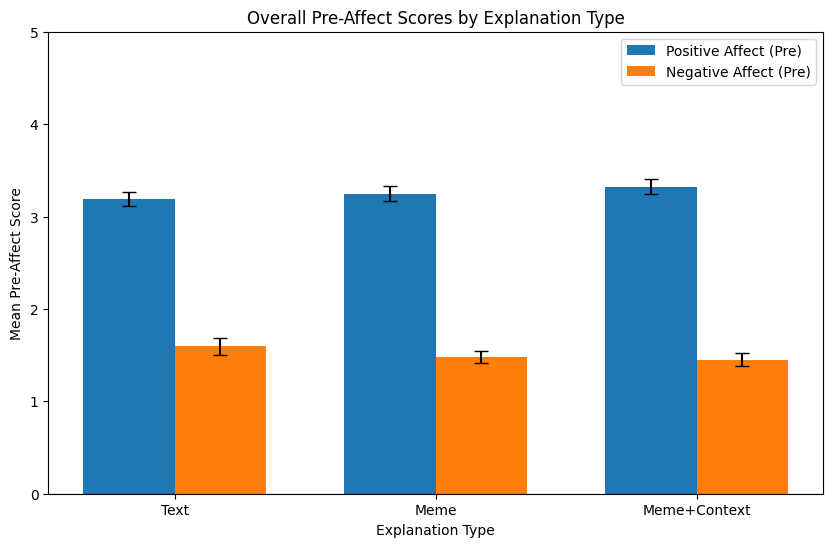

In [33]:
# --- Load the three CSV files ---
df_t   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_affect.csv', encoding='utf-8')
df_m   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_affect.csv', encoding='utf-8')
df_m_t = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_affect.csv', encoding='utf-8')

# --- Step 1: Map ordinal responses to numeric values for pre- columns ---
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5,
    "I prefer not to answer": np.nan
}

def map_pre_columns(df):
    # Process only the columns that start with "pre_"
    pre_columns = [col for col in df.columns if col.startswith("pre_")]
    for col in pre_columns:
        df[col] = df[col].map(affect_mapping)
    return df

df_t   = map_pre_columns(df_t)
df_m   = map_pre_columns(df_m)
df_m_t = map_pre_columns(df_m_t)

# --- Step 2: Define the positive and negative affect items ---
pa_items = ["active", "determined", "attentive", "inspired", "alert"]
na_items = ["afraid", "nervous", "upset", "hostile", "ashamed"]

# --- Step 3: Compute overall pre affect scores for each DataFrame ---
def compute_pre_affect(df, pa_items, na_items):
    # Build column names for pre-responses
    pre_pa_cols = [f"pre_{item}" for item in pa_items]
    pre_na_cols = [f"pre_{item}" for item in na_items]
    # Compute the average positive affect score (PA) for each participant
    df["pa_pre"] = df[pre_pa_cols].mean(axis=1)
    # Compute the average negative affect score (NA) for each participant
    df["na_pre"] = df[pre_na_cols].mean(axis=1)
    return df

df_t   = compute_pre_affect(df_t, pa_items, na_items)
df_m   = compute_pre_affect(df_m, pa_items, na_items)
df_m_t = compute_pre_affect(df_m_t, pa_items, na_items)

# --- Step 4: Compute overall statistics (mean and SEM) for pre affect scores ---
def get_overall_stats(df, col):
    mean_val = df[col].mean()
    sem_val  = df[col].sem()
    return mean_val, sem_val

# Organize the data in a dictionary by explanation type
explanation_dfs = {
    "Text": df_t,
    "Meme": df_m,
    "Meme+Context": df_m_t
}

results = {}
print("Overall Pre-Affect Scores by Explanation Type:")
for exp_type, df in explanation_dfs.items():
    # Drop rows with missing values for pa_pre or na_pre
    df_clean = df.dropna(subset=["pa_pre", "na_pre"])
    pa_mean, pa_sem = get_overall_stats(df_clean, "pa_pre")
    na_mean, na_sem = get_overall_stats(df_clean, "na_pre")
    results[exp_type] = {"pa_mean": pa_mean, "pa_sem": pa_sem, "na_mean": na_mean, "na_sem": na_sem}
    
    print(f"{exp_type}:")
    print(f"  Positive Affect (Pre): Mean = {pa_mean:.2f}, SEM = {pa_sem:.2f}")
    print(f"  Negative Affect (Pre): Mean = {na_mean:.2f}, SEM = {na_sem:.2f}")
    print("-" * 50)

# --- Step 5: Plot a grouped bar chart comparing pre affect scores ---
explanation_types = list(results.keys())
pa_means = [results[k]["pa_mean"] for k in explanation_types]
pa_sems  = [results[k]["pa_sem"] for k in explanation_types]
na_means = [results[k]["na_mean"] for k in explanation_types]
na_sems  = [results[k]["na_sem"] for k in explanation_types]

x = np.arange(len(explanation_types))
width = 0.35

plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width/2, pa_means, width, yerr=pa_sems, capsize=5, label="Positive Affect (Pre)")
bar2 = plt.bar(x + width/2, na_means, width, yerr=na_sems, capsize=5, label="Negative Affect (Pre)")

plt.xlabel("Explanation Type")
plt.ylabel("Mean Pre-Affect Score")
plt.title("Overall Pre-Affect Scores by Explanation Type")
plt.xticks(x, explanation_types)
plt.ylim(0, 5)  # since scores are on a 1-5 scale
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()

# Save the plot
save_dir = get_working_dir() / 'plots' / 'bar_plots'
save_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir / "overall_pre_affect_by_explanation.png", bbox_inches="tight")
plt.show()
plt.close()


# Coorrelation between affect change and demograhic factors

In [35]:
from scipy.stats import f_oneway


# --- Load Affect and Demographic Files for Each Explanation Type ---
# For Text:
df_t_affect = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_affect.csv', encoding='utf-8')
df_t_demo   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_demographics.csv', encoding='utf-8')

# For Meme:
df_m_affect = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_affect.csv', encoding='utf-8')
df_m_demo   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_demographics.csv', encoding='utf-8')

# For Meme+Context:
df_mt_affect = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_affect.csv', encoding='utf-8')
df_mt_demo   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_demographics.csv', encoding='utf-8')

# --- Merge Affect and Demographic Data on prolific_id ---
df_t_merged = pd.merge(df_t_affect, df_t_demo, on="prolific_id", how="inner")
df_m_merged = pd.merge(df_m_affect, df_m_demo, on="prolific_id", how="inner")
df_mt_merged = pd.merge(df_mt_affect, df_mt_demo, on="prolific_id", how="inner")

# Add explanation type labels:
df_t_merged["explanation_type"] = "Text"
df_m_merged["explanation_type"] = "Meme"
df_mt_merged["explanation_type"] = "Meme+Context"

# Concatenate merged data:
df_all = pd.concat([df_t_merged, df_m_merged, df_mt_merged], ignore_index=True)

# --- Map Affect Responses ---
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5,
    "I prefer not to answer": np.nan
}

def map_affect_columns(df, prefix):
    cols = [col for col in df.columns if col.startswith(prefix)]
    for col in cols:
        df[col] = df[col].map(affect_mapping)
    return df

df_all = map_affect_columns(df_all, "pre_")
df_all = map_affect_columns(df_all, "post_")

# --- Compute Affect Change Scores ---
# Define affect items:
pa_items = ["active", "determined", "attentive", "inspired", "alert"]
na_items = ["afraid", "nervous", "upset", "hostile", "ashamed"]

def compute_affect_diff(df, pa_items, na_items):
    pre_pa_cols  = [f"pre_{item}" for item in pa_items]
    post_pa_cols = [f"post_{item}" for item in pa_items]
    pre_na_cols  = [f"pre_{item}" for item in na_items]
    post_na_cols = [f"post_{item}" for item in na_items]
    
    # Average scores for Positive Affect
    df["pa_pre"] = df[pre_pa_cols].mean(axis=1)
    df["pa_post"] = df[post_pa_cols].mean(axis=1)
    df["pa_diff"] = df["pa_post"] - df["pa_pre"]
    
    # Average scores for Negative Affect
    df["na_pre"] = df[pre_na_cols].mean(axis=1)
    df["na_post"] = df[post_na_cols].mean(axis=1)
    df["na_diff"] = df["na_post"] - df["na_pre"]
    
    return df

df_all = compute_affect_diff(df_all, pa_items, na_items)
df_all = df_all.dropna(subset=["pa_diff", "na_diff"])

# --- Define Demographic Variables to Analyze ---
# These should be present in the demographics files.
demo_vars = ["age_group", "political_orientation", "education_level", "engagement_with_political_content"]

# --- For Each Demographic Variable, Filter Out "I prefer not to answer" or Missing, then Run ANOVA ---
save_dir = get_working_dir() / 'plots' / 'corr_dem_affect'
save_dir.mkdir(parents=True, exist_ok=True)

print("ANOVA Results for Affect Change by Demographic Factors (after filtering 'I prefer not to answer'):\n")
for demo in demo_vars:
    total_rows = df_all.shape[0]
    # Count rows with missing or "I prefer not to answer" for this demographic:
    filtered_count = df_all[(df_all[demo] == "I prefer not to answer") | (df_all[demo].isna())].shape[0]
    print(f"Demographic Variable: {demo}")
    print(f"  Total rows before filtering: {total_rows}")
    print(f"  Rows filtered out (missing or 'I prefer not to answer'): {filtered_count}")
    
    # Filter out these rows:
    df_demo = df_all[(df_all[demo] != "I prefer not to answer") & (~df_all[demo].isna())]
    remaining = df_demo.shape[0]
    print(f"  Remaining rows after filtering: {remaining}")
    
    # Get unique levels for this demographic (assumed to be categorical):
    levels = sorted(df_demo[demo].unique())
    
    # Prepare groups for ANOVA:
    groups_pa = [df_demo[df_demo[demo] == level]["pa_diff"] for level in levels]
    groups_na = [df_demo[df_demo[demo] == level]["na_diff"] for level in levels]
    
    # One-way ANOVA for positive affect change:
    f_stat_pa, p_val_pa = f_oneway(*groups_pa)
    # One-way ANOVA for negative affect change:
    f_stat_na, p_val_na = f_oneway(*groups_na)
    
    print(f"  ANOVA for Positive Affect Change (pa_diff): F = {f_stat_pa:.2f}, p = {p_val_pa:.3f}")
    if p_val_pa < 0.05:
        print("  => Significant differences in positive affect change among groups.")
    else:
        print("  => No significant differences in positive affect change among groups.")
    
    print(f"  ANOVA for Negative Affect Change (na_diff): F = {f_stat_na:.2f}, p = {p_val_na:.3f}")
    if p_val_na < 0.05:
        print("  => Significant differences in negative affect change among groups.")
    else:
        print("  => No significant differences in negative affect change among groups.")
    
    # --- Generate and Save Box Plots ---
    plt.figure(figsize=(8, 6))
    df_demo.boxplot(column="pa_diff", by=demo)
    plt.title(f"Positive Affect Change (pa_diff) by {demo}")
    plt.suptitle("")
    plt.xlabel(demo)
    plt.ylabel("pa_diff")
    plt.axhline(0, color='black', linewidth=0.8)
    plt.savefig(save_dir / f"boxplot_pa_diff_by_{demo}.png", bbox_inches="tight")
    plt.close()
    
    plt.figure(figsize=(8, 6))
    df_demo.boxplot(column="na_diff", by=demo)
    plt.title(f"Negative Affect Change (na_diff) by {demo}")
    plt.suptitle("")
    plt.xlabel(demo)
    plt.ylabel("na_diff")
    plt.axhline(0, color='black', linewidth=0.8)
    plt.savefig(save_dir / f"boxplot_na_diff_by_{demo}.png", bbox_inches="tight")
    plt.close()
    
    print("-" * 60)

print("\nNote: It is crucial that each participant's affect change is linked with their demographic response.\n"
      "Thus, the sample sizes for the affect change variables and the demographic factors are the same, ensuring\n"
      "that the analysis (e.g., ANOVA) compares paired data from the same individuals.")

ANOVA Results for Affect Change by Demographic Factors (after filtering 'I prefer not to answer'):

Demographic Variable: age_group
  Total rows before filtering: 313
  Rows filtered out (missing or 'I prefer not to answer'): 1
  Remaining rows after filtering: 312
  ANOVA for Positive Affect Change (pa_diff): F = 0.52, p = 0.667
  => No significant differences in positive affect change among groups.
  ANOVA for Negative Affect Change (na_diff): F = 1.96, p = 0.120
  => No significant differences in negative affect change among groups.
------------------------------------------------------------
Demographic Variable: political_orientation
  Total rows before filtering: 313
  Rows filtered out (missing or 'I prefer not to answer'): 4
  Remaining rows after filtering: 309
  ANOVA for Positive Affect Change (pa_diff): F = 0.39, p = 0.818
  => No significant differences in positive affect change among groups.
  ANOVA for Negative Affect Change (na_diff): F = 0.74, p = 0.567
  => No signifi

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

# Corr affect change with engagement w/ political content numeric colapse for all expl types

In [38]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Mapping for affect responses.
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5
}

# Mapping for engagement_with_political_content responses.
engagement_mapping = {
    "Never": 1,
    "Rarely": 2,
    "Sometimes": 3,
    "Often": 4,
    "Very Frequently": 5
}

# Compute affect changes from an affect file.
# Positive affect items: alert, inspired, determined, attentive, active.
# Negative affect items: upset, hostile, ashamed, nervous, afraid.
def compute_affect_changes(df_affect):
    positive_items = ["alert", "inspired", "determined", "attentive", "active"]
    negative_items = ["upset", "hostile", "ashamed", "nervous", "afraid"]
    
    # Map all affect responses to numeric values.
    for col in df_affect.columns:
        if df_affect[col].dtype == object:
            df_affect[col] = df_affect[col].str.strip().map(affect_mapping)
    
    pos_diffs = []
    for item in positive_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            pos_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if pos_diffs:
        pos_change = pd.concat(pos_diffs, axis=1).mean(axis=1)
    else:
        pos_change = pd.Series(np.nan, index=df_affect.index)
    
    neg_diffs = []
    for item in negative_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            neg_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if neg_diffs:
        neg_change = pd.concat(neg_diffs, axis=1).mean(axis=1)
    else:
        neg_change = pd.Series(np.nan, index=df_affect.index)
    
    return pos_change, neg_change

# Process one file pair (affect file and demographics file) for a given explanation type.
def process_file_pair_engagement_affect(affect_filename, demo_filename):
    # Load the affect file.
    affect_path = get_working_dir() / 'data' / 'processed' / affect_filename
    df_affect = pd.read_csv(affect_path, encoding='utf-8', dtype={'prolific_id': str})
    pos_change, neg_change = compute_affect_changes(df_affect)
    df_affect["positive_affect_change"] = pos_change
    df_affect["negative_affect_change"] = neg_change
    
    # Load the corresponding demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    # Filter out rows where engagement_with_political_content is "I prefer not to answer".
    df_demo = df_demo[df_demo["engagement_with_political_content"] != "I prefer not to answer"]
    # Map engagement_with_political_content to numeric values.
    df_demo["engagement_numeric"] = df_demo["engagement_with_political_content"].str.strip().map(engagement_mapping)
    
    # Merge the affect data with demographics on prolific_id.
    df_merged = pd.DataFrame({
        'prolific_id': df_demo['prolific_id'],  # Use the valid prolific_ids
        "engagement_numeric": df_demo["engagement_numeric"],
        'positive_affect_change': df_affect['positive_affect_change'],
        'negative_affect_change': df_affect['negative_affect_change']
    })
    return df_merged

# Define file pairs for each explanation type (affect and demographics files).
# Adjust file names if needed.
file_pairs = [
    ("t_affect.csv", "t_demographics.csv"),
    ("m_affect.csv", "m_demographics.csv"),
    ("m_t_affect.csv", "m_t_demographics.csv")
]

# Process each pair and collect the merged data.
merged_dfs = []
for affect_file, demo_file in file_pairs:
    df_merged = process_file_pair_engagement_affect(affect_file, demo_file)
    merged_dfs.append(df_merged)

# Concatenate all merged data.
df_all = pd.concat(merged_dfs, ignore_index=True)
df_all = df_all.dropna(subset=["positive_affect_change", "negative_affect_change", "engagement_numeric"])

if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    # Compute Pearson correlation between positive affect change and political engagement.
    corr_pos, p_pos = pearsonr(df_all["positive_affect_change"], df_all["engagement_numeric"])
    # Compute Pearson correlation between negative affect change and political engagement.
    corr_neg, p_neg = pearsonr(df_all["negative_affect_change"], df_all["engagement_numeric"])
    
    print("Pearson correlation between affect change and political engagement (collapsed across all explanation types):")
    print(f"  Positive Affect Change: r = {corr_pos:.3f}, p = {p_pos:.3f}")
    print(f"  Negative Affect Change: r = {corr_neg:.3f}, p = {p_neg:.3f}")


Pearson correlation between affect change and political engagement (collapsed across all explanation types):
  Positive Affect Change: r = 0.133, p = 0.018
  Negative Affect Change: r = -0.091, p = 0.108


In [36]:
# Calculate means and SEM for pa_diff grouped by engagement_with_political_content
engagement_means = df_all.groupby("engagement_with_political_content")["pa_diff"].mean()
engagement_sems  = df_all.groupby("engagement_with_political_content")["pa_diff"].sem()

print("Means of Positive Affect Change (pa_diff) by Engagement with Political Content:")
print(engagement_means)
print("\nStandard Error of the Mean (SEM) for pa_diff by Engagement with Political Content:")
print(engagement_sems)

Means of Positive Affect Change (pa_diff) by Engagement with Political Content:
engagement_with_political_content
Never             -0.044444
Often             -0.031053
Rarely            -0.246809
Sometimes         -0.201020
Very Frequently    0.018182
Name: pa_diff, dtype: float64

Standard Error of the Mean (SEM) for pa_diff by Engagement with Political Content:
engagement_with_political_content
Never              0.087903
Often              0.054650
Rarely             0.083453
Sometimes          0.060791
Very Frequently    0.074540
Name: pa_diff, dtype: float64
